In [25]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
from sklearn.cross_validation import train_test_split

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
with open('/Users/anusha/Desktop/Language_Detection/data/eng.txt','rt') as f:
    text1 = f.read().lower()
with open('/Users/anusha/Desktop/Language_Detection/data/frn.txt','rt') as f:
    text2 = f.read().lower()
print('corpus length:', len(text1))
print('corpus length:', len(text2))

corpus length: 10746
corpus length: 12009


In [45]:
y1 = np.tile(0,len(text1))
y2 = np.tile(1,len(text2))
x_train_eng, x_test_eng, y_train_eng, y_test_eng = train_test_split(text1, y1, test_size=0.2)
x_train_frn, x_test_frn, y_train_frn, y_test_frn = train_test_split(text2, y2, test_size=0.2)

In [46]:
print(len(x_train_eng), len(x_test_eng))

8596 2150


In [201]:
chars_eng = sorted(list(set(text1)))
chars_fr = sorted(list(set(text2)))
chars = sorted(list(set(chars_eng + chars_fr)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen= 40
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])

print('nb sequences:', len(sentences_eng_tr))

##test set prepare
sentences_eng_test = []
string_eng_test= []
step_test=20
for i in range(int(0.8*len(text1)) - maxlen,len(text1) - maxlen-step_test, step_test):
    sentences_eng_test.append(text1[i: i + maxlen])
    string_eng_test.append(text1[i+maxlen:i+maxlen+5])
print('nb sequences:', len(sentences_eng_test))

print('Vectorization...')
X_eng = np.zeros(shape=(len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng = np.zeros(shape=(len(sentences_eng_tr), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng[i, t, char_indices[char]] = 1
    y_eng[i, char_indices[next_chars_eng_tr[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.008)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

total chars: 44
nb sequences: 8556
nb sequences: 107
Vectorization...
Build model...


In [257]:
#generating french model



##training set prepare
maxlen= 40
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

print('nb sequences:', len(sentences_fr_tr))
##test set prepare
sentences_fr_test = []
string_fr_test= []
step_test=20
for i in range(int(0.8*len(text2)) - maxlen,len(text2) - maxlen, step_test):
    sentences_fr_test.append(text2[i: i + maxlen])
    string_fr_test.append(text2[i+maxlen:i+maxlen+5])
print('nb sequences:', len(sentences_fr_test))

print('Vectorization...')
X_fr = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr[i, t, char_indices[char]] = 1
    y_fr[i, char_indices[next_chars_fr_tr[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model2 = Sequential()
model2.add(LSTM(128, input_shape=(maxlen, len(chars))))
model2.add(Dense(len(chars)))
model2.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

nb sequences: 9567
nb sequences: 121
Vectorization...
Build model...


In [258]:
import csv
sentences_fr_test =sentences_fr_test[:100]
string_fr_test=string_fr_test[:100]
sentences_eng_test =sentences_eng_test[:100]
string_eng_test=string_eng_test[:100]

sentences_test = sentences_fr_test + sentences_eng_test
string_test = string_fr_test + string_eng_test

with open("test_50.csv", 'wt') as f:
    w = csv.writer(f, dialect='excel')
    #for row in string_test:
    w.writerow(string_test)

In [259]:
def vectorize(sentence, chars , char_indices ):
    X = np.zeros((1, maxlen, len(chars)), dtype=np.bool)
    for t, char in enumerate(sentence):
        X[0, t, char_indices[char]] = 1
    return X

In [260]:
def get_scores_for_model(seed,next_string, model,chars,char_indices):
    sentence =seed
    x = np.zeros((5, maxlen, len(chars)))

    x[0] = vectorize(seed,chars,char_indices)
    x[1] = vectorize(seed[1:]+next_string[:1],chars,char_indices)
    x[2] = vectorize(seed[2:]+next_string[:2],chars,char_indices)
    x[3] = vectorize(seed[3:]+next_string[:3],chars,char_indices)
    x[4] = vectorize(seed[4:]+next_string[:4],chars,char_indices)
    probs_term = []
    for i in range(5):
        preds = model.predict(x[i].reshape(1,40,44), verbose=0)[0]
        preds = np.log(preds)
        probs_term.append(preds[char_indices[next_string[i]]])

    return probs_term

In [203]:
import csv
# train the model, output generated text after each iteration
for iteration in range(1, 2):
    print()
    #print('-' * 50)
    print('Iteration', iteration)
    a1=model.fit(X_eng, y_eng,
              batch_size=128,
              epochs=20)
    model_eng_json = model.to_json()
    with open("/Users/anusha/Desktop/Language_Detection/model/model_eng_"+str(iteration)+".json", "w") as json_file:
        json_file.write(model_eng_json)
    # serialize weights to HDF5
    model.save_weights("/Users/anusha/Desktop/Language_Detection/weights/model_eng_"+ str(iteration) +".h5")
    print("Saved model to disk")

    sentences_fr_test =sentences_fr_test[:100]
    string_fr_test=string_fr_test[:100]
    sentences_eng_test =sentences_eng_test[:100]
    string_eng_test=string_eng_test[:100]
    
    #sentence=
    prob_english=[]
    for i in range(len(sentences_eng_test)):
        prob_english.append(get_scores_for_model(sentences_eng_test[i], string_eng_test[i], model,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_english.append(get_scores_for_model(sentences_fr_test[i], string_fr_test[i], model, chars, char_indices))
    #sentence = text1[start_index: start_index + maxlen]
    #print (prob_english)

    with open("/Users/anusha/Desktop/Language_Detection/prob_eng/output_prob_" + str(iteration) + ".csv", 'wt') as f:
        w = csv.writer(f, dialect='excel')
        for row in prob_english:
            w.writerow(row)
    with open("/Users/anusha/Desktop/Language_Detection/model/loss_eng" + ".csv", 'a') as f:
        w = csv.writer(f, dialect='excel')
        w.writerow(a1.history['loss'])


Iteration 1
Epoch 1/20
8556/8556 [==============================] - 5s 616us/step - loss: 2.8295 - acc: 0.1999
Epoch 2/20
8556/8556 [==============================] - 4s 436us/step - loss: 2.2616 - acc: 0.3553
Epoch 3/20
8556/8556 [==============================] - 4s 440us/step - loss: 1.9802 - acc: 0.4331
Epoch 4/20
8556/8556 [==============================] - 4s 439us/step - loss: 1.7827 - acc: 0.4870
Epoch 5/20
8556/8556 [==============================] - 4s 441us/step - loss: 1.6062 - acc: 0.5337
Epoch 6/20
8556/8556 [==============================] - 4s 458us/step - loss: 1.4573 - acc: 0.5670
Epoch 7/20
8556/8556 [==============================] - 4s 467us/step - loss: 1.3239 - acc: 0.6064
Epoch 8/20
8556/8556 [==============================] - 4s 446us/step - loss: 1.2132 - acc: 0.6403
Epoch 9/20
8556/8556 [==============================] - 4s 451us/step - loss: 1.1065 - acc: 0.6683
Epoch 10/20
8556/8556 [==============================] - 4s 449us/step - loss: 1.0197 - acc: 0.6

In [255]:
print (len(prob_english))

200


In [261]:
import csv
# train the model, output generated text after each iteration


for iteration in range(1, 2):
    print()
    #print('-' * 50)
    print('Iteration', iteration)
    a2=model2.fit(X_fr, y_fr,
              batch_size=128,
              epochs=20)
    model_fr_json = model2.to_json()
    with open("/Users/anusha/Desktop/Language_Detection/model/model_fr_"+str(iteration)+".json", "w") as json_file:
        json_file.write(model_fr_json)
    # serialize weights to HDF5
    model2.save_weights("/Users/anusha/Desktop/Language_Detection/weights/model_fr_"+ str(iteration) +".h5")
    print("Saved model to disk")

        
    sentences_fr_test =sentences_fr_test[:100]
    string_fr_test=string_fr_test[:100]
    sentences_eng_test =sentences_eng_test[:100]
    string_eng_test=string_eng_test[:100]
    #sentence=
    prob_fr=[]
    for i in range(len(sentences_eng_test)):
        prob_fr.append(get_scores_for_model(sentences_eng_test[i], string_eng_test[i], model2,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_fr.append(get_scores_for_model(sentences_fr_test[i], string_fr_test[i], model2, chars, char_indices))

    #print (prob_fr)
    
    with open("/Users/anusha/Desktop/Language_Detection/prob_fr/output_prob_" + str(iteration) + ".csv", 'wt') as f:
        w = csv.writer(f, dialect='excel')
        for row in prob_fr:
            w.writerow(row)
    with open("/Users/anusha/Desktop/Language_Detection/model/loss_fr" + ".csv", 'a') as f:
        w = csv.writer(f, dialect='excel')
        w.writerow(a2.history['loss'])


Iteration 1
Epoch 1/20
9567/9567 [==============================] - 6s 645us/step - loss: 2.6520 - acc: 0.2356
Epoch 2/20
9567/9567 [==============================] - 5s 488us/step - loss: 2.0689 - acc: 0.3848
Epoch 3/20
9567/9567 [==============================] - 5s 486us/step - loss: 1.8081 - acc: 0.4540
Epoch 4/20
9567/9567 [==============================] - 4s 465us/step - loss: 1.6149 - acc: 0.5010
Epoch 5/20
9567/9567 [==============================] - 5s 471us/step - loss: 1.4690 - acc: 0.5519
Epoch 6/20
9567/9567 [==============================] - 4s 469us/step - loss: 1.3306 - acc: 0.5920
Epoch 7/20
9567/9567 [==============================] - 4s 467us/step - loss: 1.2063 - acc: 0.6268
Epoch 8/20
9567/9567 [==============================] - 4s 468us/step - loss: 1.0837 - acc: 0.6583
Epoch 9/20
9567/9567 [==============================] - 4s 468us/step - loss: 0.9893 - acc: 0.6887
Epoch 10/20
9567/9567 [==============================] - 5s 472us/step - loss: 0.8914 - acc: 0.7

In [262]:
print (len(prob_fr))

200


In [263]:
from keras.models import model_from_json
json_file = open('/Users/anusha/Desktop/Language_Detection/model/model_eng_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model3 = model_from_json(loaded_model_json)
# load weights into new model
model3.load_weights("/Users/anusha/Desktop/Language_Detection/weights/model_eng_1.h5")
print("Loaded model from disk")
optimizer = RMSprop(lr=0.008)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer)

Loaded model from disk


In [264]:
from keras.models import model_from_json
json_file = open('/Users/anusha/Desktop/Language_Detection/model/model_eng_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model3 = model_from_json(loaded_model_json)
model3.load_weights("/Users/anusha/Desktop/Language_Detection/weights/model_eng_1.h5")

In [265]:
for diversity in [ 1.0]:
    sentences_fr_test =sentences_fr_test[:100]
    string_fr_test=string_fr_test[:100]
    sentences_eng_test =sentences_eng_test[:100]
    string_eng_test=string_eng_test[:100]
    
    prob_fr=[]
    for i in range(len(sentences_fr_test)):
        prob_fr.append(get_scores_for_model(sentences_eng_test[i], string_eng_test[i], model3,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_fr.append(get_scores_for_model(sentences_fr_test[i], string_fr_test[i], model3, chars, char_indices))
    #sentence = text1[start_index: start_index + maxlen]
    #print (prob_english)
    with open("/Users/anusha/Desktop/Language_Detection/prob_eng/output_prob_" + str(1) + ".csv", 'wt') as f:
        w = csv.writer(f, dialect='excel')
        w.writerows(prob_fr)
    
    """prob_fr=[]
    prob_eng=[]
    for i in range(len(sentences_eng_test)):
        prob_eng.append(get_scores_for_model(sentences_eng_test[i], string_eng_test[i], model3,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_fr.append(get_scores_for_model(sentences_fr_test[i], string_fr_test[i], model3, chars, char_indices))
    #print (prob_fr)
    with open("/Users/anusha/Desktop/Language_Detection/prob_eng/output_prob_" + str(1) + ".csv", 'wt') as f:
        w = csv.writer(f, dialect='excel')
        w.writerows(prob_eng)
    with open("/Users/anusha/Desktop/Language_Detection/prob_fr/output_prob_" + str(1) + ".csv", 'wt') as f:
        w = csv.writer(f, dialect='excel')
        w.writerows(prob_fr)"""

In [269]:
def predict_language(prob_english, prob_fr):
    y = [1] * len(prob_english)
    probs_eng = []
    probs_frn = []
    for i in range(len(prob_english)):
        sum_english = 0
        sum_fr = 0
        #print(len(prob_english), len(prob_fr))
        for j in range(len(prob_english[0])):
            #print(prob_english[i][j])
            sum_english += float(prob_english[i][j])
            sum_fr += float(prob_fr[i][j])
        sum_english = np.exp(sum_english)
        sum_fr = np.exp(sum_fr)
        if sum_english < sum_fr:
            y[i] = 0
        if sum_fr == 0.0:
            sum_fr = 0.0000000001
        probs_eng.append(sum_english)
        probs_frn.append(sum_fr)
    return y, probs_eng, probs_frn

----------------- Iteration: 1 --------------------
2.3421566234131218e-23 0.9529005973712862
[[81 19]
 [13 87]]
0.84


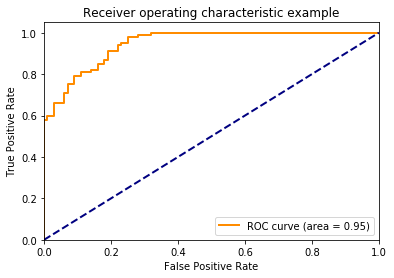

In [270]:
import csv
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, auc, roc_curve
for iter in range(1,2):
    print("----------------- Iteration: " + str(iter) + " --------------------")
    prob_english=[]
    with open("/Users/anusha/Desktop/Language_Detection/prob_eng/output_prob_" + str(iter) + ".csv", 'rt') as f:
            w = csv.reader(f, delimiter=',')
            prob_english = list(w)

    prob_fr=[]
    with open("/Users/anusha/Desktop/Language_Detection/prob_fr/output_prob_" + str(iter) + ".csv", 'rt') as f:
            w = csv.reader(f, delimiter=',')
            prob_fr = list(w)
    
    #print(prob_english)
    #print("\n\n\n\n")
    #print(prob_fr)
    true_labels = ([1] * 100) + ([0] * 100)

    pred_y, logprob_english, logprob_fr = predict_language(prob_english, prob_fr)
    
    print(min(logprob_fr), max(logprob_fr))
    y_hat = np.array([a/b for (a, b) in zip(logprob_english, logprob_fr)])
    #roc_auc_score(true_labels, y_hat)
    #print(true_labels, pred_y)
    print (confusion_matrix(true_labels, pred_y))
    print (accuracy_score(true_labels, pred_y))
    #print (y_hat)
    try:
        fpr, tpr, _ = roc_curve(true_labels, y_hat)
    except:
        continue
    roc_auc = auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()